In [ ]:
!pip install -U bitsandbytes transformers accelerate

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

In [ ]:
# Make sure to upload utils.py
files.upload()

In [3]:
import os
import sys

path = os.getcwd()
while True:
    if 'utils.py' in os.listdir(path):
        if path not in sys.path:
            sys.path.append(path)
        break
    new_path = os.path.dirname(path)
    if new_path == path:
        print("utils.py not found in any parent folder.")
        break
    path = new_path

import utils
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch


c:\Users\User\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.hf_login("HF_TOKEN")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [ ]:
model_id = 'mistralai/Mistral-7B-Instruct-v0.3'

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quantization_config,
    attn_implementation="eager"
    )

In [4]:
# files.upload()
scitail_test = pd.read_csv('../../../Datasets/Scitail/scitail_test.csv')

In [1]:
scitail_test.info()

NameError: name 'scitail_test' is not defined

In [ ]:
scitail_test.head()

In [ ]:
# Find the max_length for tokenization to avoid wasting computing.
utils.find_max_length(scitail_test, tokenizer=tokenizer, dataset_type='scitail')

In [ ]:
# Define dataset and create a dataloader.
dataset_test = utils.MyDataset(dataframe=scitail_test,
                               tokenizer=tokenizer,
                               dataset_type='scitail',
                               prompt_max_length=117,
                               label_max_length=3)

batch_size = 16 # Change batch size according to GPU
dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False) 

In [ ]:
# # Test
# from importlib import reload
# reload(utils)
# predictions, gold_labels = utils.test_run(model=model,
#                                           dataloader=dataloader,
#                                           tokenizer=tokenizer,
#                                           dataset_type='scitail')


In [ ]:
# Create checkpoint
checkpoint_dir = "/content/drive/MyDrive/eval_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
print("Checkpoint directory:", checkpoint_dir)

checkpoint_path = os.path.join(
    checkpoint_dir,
    f"checkpoint_scitail_{model_id.split('/')[1]}.pt".replace('-', '_')
)

In [19]:
from importlib import reload
reload(utils)
checkpoint_path = utils.create_checkpoint_path(model_id='mistralai/Mistral-7B-Instruct-v0.3', name='scitail')

Saving to: c:\Users\User\Desktop\DAMA_EAP\NLI_Study\Notebooks\Scitail_Notebooks\scitail-Mistral-7B-Instruct-v0.3-zero-shot\checkpoint_scitail_Mistral_7B_Instruct_v0.3.pt


In [5]:
checkpoint_path = 'checkpoint_scitail_Mistral_7B_Instruct_v0.3.pt'

In [ ]:
from tqdm import tqdm

# Load checkpoint if it exists
predicted_labels, gold_labels, no_answer, start_batch = utils.load_checkpoint(checkpoint_path=checkpoint_path)


with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Evaluating", unit="batch")):
        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        # Get outputs
        outputs = model.generate(input_ids=input_ids_batch, attention_mask=attention_mask_batch, max_new_tokens=6)
        outputs_decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        predicted_labels_batch, no_answer_batch = utils.get_predictions(outputs_decoded=outputs_decoded, no_answer=no_answer, dataset_type='scitail')
        predicted_labels.extend(predicted_labels_batch)
        gold_labels.extend(gold_labels_batch)
        no_answer += no_answer_batch

        # Save checkpoint
        if i % 50 == 0 or i == len(dataloader) - 1:
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "no_answer": no_answer,
                        "batch_no": i+1}, checkpoint_path)

            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")

In [20]:
predicted_labels, gold_labels, no_answer, _ = utils.load_checkpoint(checkpoint_path=checkpoint_path)
print(f"The model was unable to give an answer to {no_answer} out of {len(predicted_labels)} questions.")

Checkpoint found.
The model was unable to give an answer to 0 out of 2126 questions.


In [21]:
predicted_labels.count('entails')

1070

Accuracy: 0.7822.
 F1 Score: 0.5254.
 Matthew's Correlation Coefficient: 0.5912.
 Cohen's Kappa Score: 0.5747.


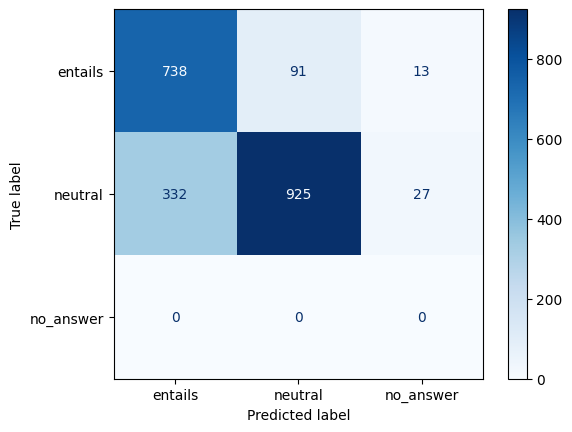

In [8]:
# Calculate metrics
# from importlib import reload
# reload(utils)
utils.evaluate_metrics(predicted_labels=predicted_labels, gold_labels=gold_labels, dataset_type='scitail')

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gold_labels, predicted_labels); cm

array([[738,  91,  13],
       [332, 925,  27],
       [  0,   0,   0]])

In [20]:
set(predicted_labels)

{'entails', 'neutral', 'no_answer'}

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

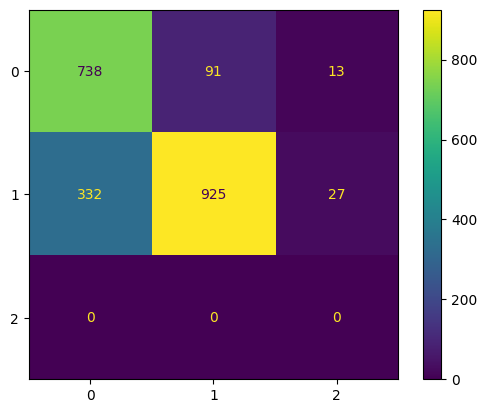

In [18]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=set(gold_labels))
cm_display.plot()